## 1. Сгенерировать пакетом hopfield-tracking датасет spdsim с параметрами по умолчанию

In [34]:
import vispy
# selecting sub-backend behind jupyter_rfb:
# 1) pyglfw has high priority if present
# 2) to use any other backend, install then designate as default
# 4) use jupyter_rfb, it then selects the sub-backend according to config
# 5) enable jupyterlab extensions for interactive widget provided by jupyter_rfb

# only needed in jhub2, jhub and jlab-hpc can't run opengl at all, locally auto-selected backend is OK
vispy.config.update(default_backend='egl')
vispy.use('jupyter_rfb')

RFBOutputContext()

RFBOutputContext()

CanvasBackend(css_height='768px', css_width='1024px')
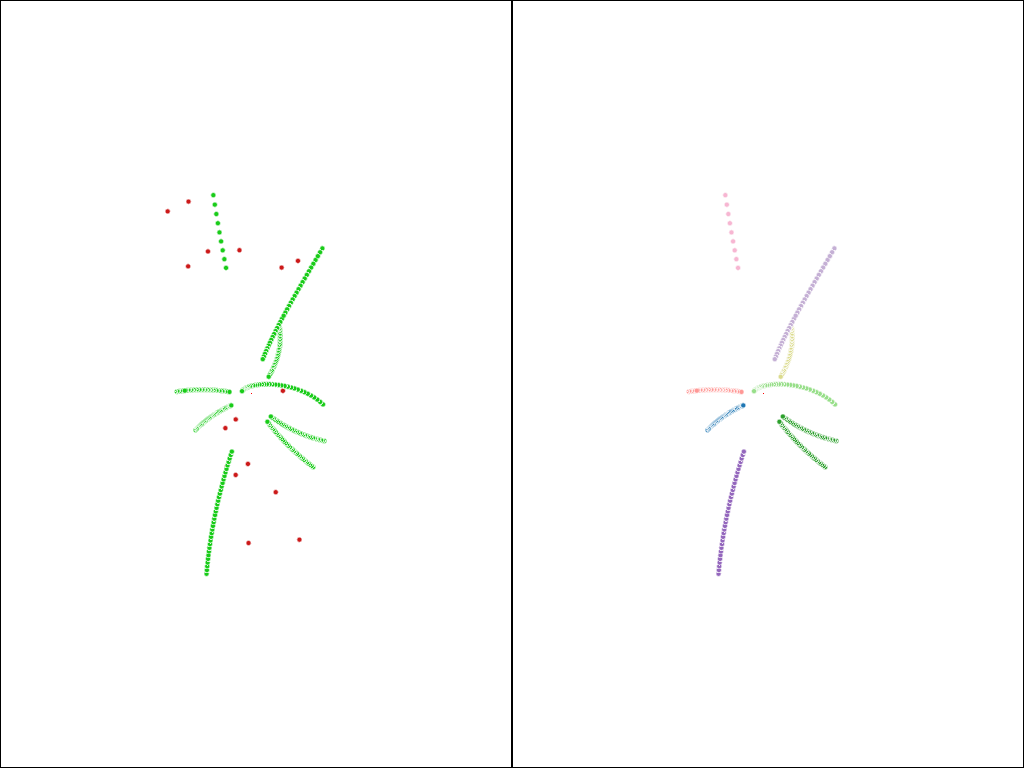

In [35]:
from segment.candidate import gen_seg_layered
from segment.track import gen_seg_track_layered, gen_seg_track_sequential
from tracking.plot import plot_event, plot_seg_diff
from vispy.scene import SceneCanvas
from datasets import get_hits

canvas = SceneCanvas(bgcolor='white', size=(1000, 1500))
grid = canvas.central_widget.add_grid()

event = get_hits('spdsim', 1)
plot_event(event)

In [36]:
event

,x,y,z,layer,track,event_id
0,-209.584854,-170.183390,1559.097578,1,0,0
1,-217.541150,-187.255211,1661.592519,2,0,0
2,-224.941332,-204.686077,1764.396771,3,0,0
3,-231.294118,-222.848037,1867.600713,4,0,0
4,-236.770451,-241.536697,1970.451030,5,0,0
...,...,...,...,...,...,...
300,255.896666,-666.003802,2021.544643,26,-1,0
301,122.939232,-772.037489,4.052692,30,-1,0
302,-248.305015,-812.920248,1801.903567,34,-1,0
303,331.737882,-650.868596,-1571.049297,27,-1,0


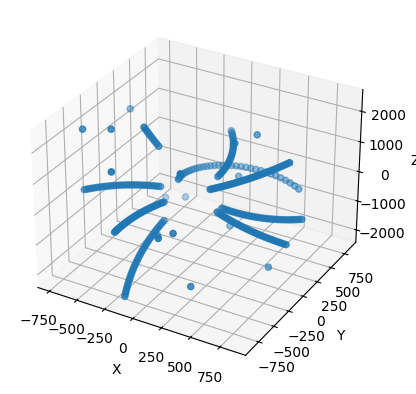

In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw_event(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = df['x']
    y = df['y']
    z = df['z']

    ax.scatter(x, y, z)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

draw_event(event)

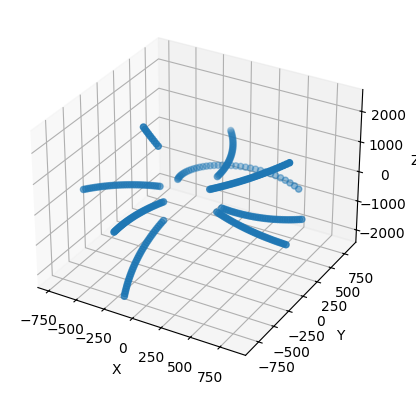

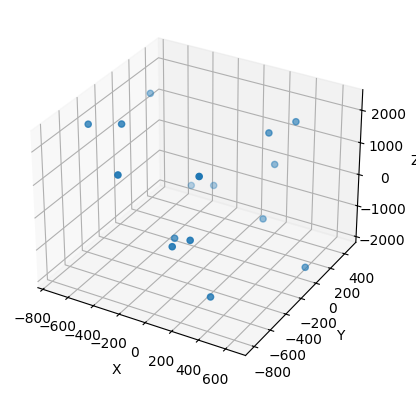

In [75]:
df_track = event.loc[event['track'] >= 0]
df_noise = event.loc[event['track'] == -1]

draw_event(df_track)
draw_event(df_noise)

## 2. Добавить цилиндрические координаты хитов вокруг оси z

In [39]:
from tracking.hit import add_cylindric_coordinates

add_cylindric_coordinates(event)

,x,y,z,layer,track,event_id,r,phi
0,-209.584854,-170.183390,1559.097578,1,0,0,269.978142,-2.459576
1,-217.541150,-187.255211,1661.592519,2,0,0,287.034259,-2.430873
2,-224.941332,-204.686077,1764.396771,3,0,0,304.129895,-2.403306
3,-231.294118,-222.848037,1867.600713,4,0,0,321.182529,-2.374790
4,-236.770451,-241.536697,1970.451030,5,0,0,338.231020,-2.346230
...,...,...,...,...,...,...,...,...
300,255.896666,-666.003802,2021.544643,26,-1,0,713.473312,-1.203961
301,122.939232,-772.037489,4.052692,30,-1,0,781.764632,-1.412882
302,-248.305015,-812.920248,1801.903567,34,-1,0,849.996888,-1.867244
303,331.737882,-650.868596,-1571.049297,27,-1,0,730.534018,-1.099431


## 3. Реализовать с помощью любого метода машинного обучения классификацию хитов на настоящие и шумовые. Визуализировать результат для одного тестового события. Посчитать f1_score классификации на тестовом датасете spdsim с параметрами по умолчанию.

In [40]:
event.to_csv('hits_filter2.csv', index=False)

In [41]:
import pandas as pd

df = pd.read_csv('hits_filter2.csv')
df

,x,y,z,layer,track,event_id,r,phi
0,-209.584854,-170.183390,1559.097578,1,0,0,269.978142,-2.459576
1,-217.541150,-187.255211,1661.592519,2,0,0,287.034259,-2.430873
2,-224.941332,-204.686077,1764.396771,3,0,0,304.129895,-2.403306
3,-231.294118,-222.848037,1867.600713,4,0,0,321.182529,-2.374790
4,-236.770451,-241.536697,1970.451030,5,0,0,338.231020,-2.346230
...,...,...,...,...,...,...,...,...
300,255.896666,-666.003802,2021.544643,26,-1,0,713.473312,-1.203961
301,122.939232,-772.037489,4.052692,30,-1,0,781.764632,-1.412882
302,-248.305015,-812.920248,1801.903567,34,-1,0,849.996888,-1.867244
303,331.737882,-650.868596,-1571.049297,27,-1,0,730.534018,-1.099431


In [47]:
import numpy as np
y_train = df['track'].to_numpy() 
y_train = np.where(y_train >= 0, 1, 0)
y_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [48]:
df_train = df.drop('event_id', axis=1)
df_train

,x,y,z,layer,track,r,phi
0,-209.584854,-170.183390,1559.097578,1,0,269.978142,-2.459576
1,-217.541150,-187.255211,1661.592519,2,0,287.034259,-2.430873
2,-224.941332,-204.686077,1764.396771,3,0,304.129895,-2.403306
3,-231.294118,-222.848037,1867.600713,4,0,321.182529,-2.374790
4,-236.770451,-241.536697,1970.451030,5,0,338.231020,-2.346230
...,...,...,...,...,...,...,...
300,255.896666,-666.003802,2021.544643,26,-1,713.473312,-1.203961
301,122.939232,-772.037489,4.052692,30,-1,781.764632,-1.412882
302,-248.305015,-812.920248,1801.903567,34,-1,849.996888,-1.867244
303,331.737882,-650.868596,-1571.049297,27,-1,730.534018,-1.099431


In [49]:
x_train = df_train.to_numpy()
x_train

array([[-2.09584854e+02, -1.70183390e+02,  1.55909758e+03, ...,
         0.00000000e+00,  2.69978142e+02, -2.45957594e+00],
       [-2.17541150e+02, -1.87255211e+02,  1.66159252e+03, ...,
         0.00000000e+00,  2.87034259e+02, -2.43087307e+00],
       [-2.24941332e+02, -2.04686077e+02,  1.76439677e+03, ...,
         0.00000000e+00,  3.04129895e+02, -2.40330570e+00],
       ...,
       [-2.48305015e+02, -8.12920248e+02,  1.80190357e+03, ...,
        -1.00000000e+00,  8.49996888e+02, -1.86724393e+00],
       [ 3.31737882e+02, -6.50868596e+02, -1.57104930e+03, ...,
        -1.00000000e+00,  7.30534018e+02, -1.09943087e+00],
       [ 1.67178868e+02,  2.93965020e+02, -1.51478037e+03, ...,
        -1.00000000e+00,  3.38177774e+02,  1.05370708e+00]])

### Генерация тестового датасета

RFBOutputContext()

RFBOutputContext()

CanvasBackend(css_height='768px', css_width='1024px')
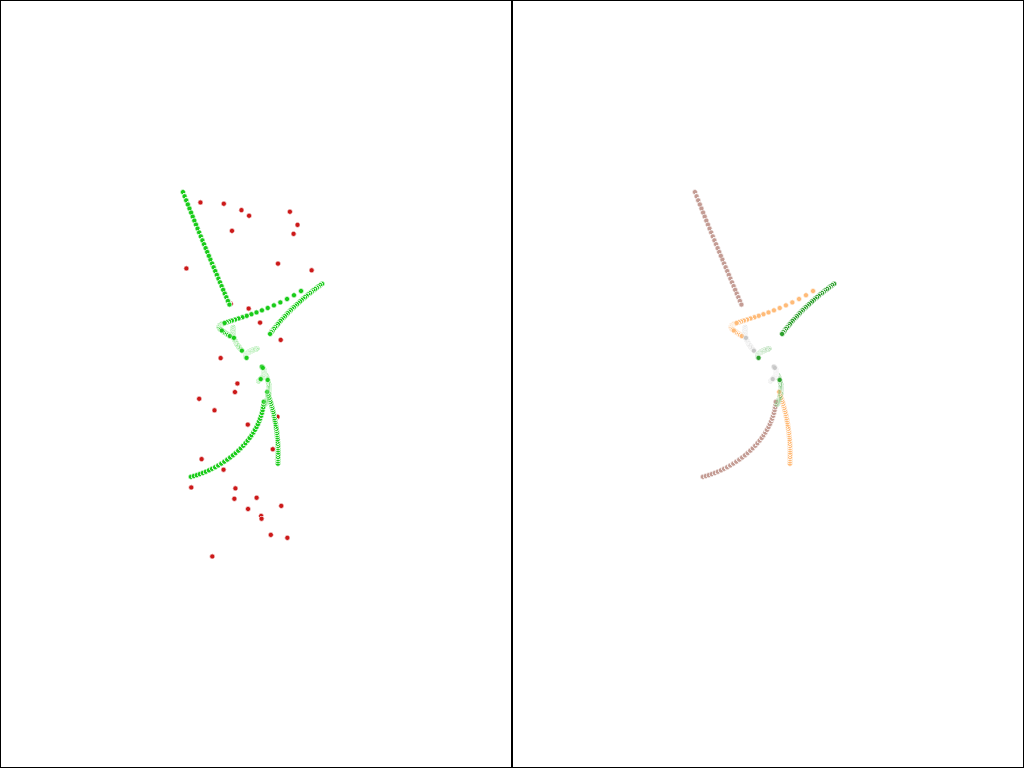

In [16]:
from segment.candidate import gen_seg_layered
from segment.track import gen_seg_track_layered, gen_seg_track_sequential
from tracking.plot import plot_event, plot_seg_diff
from vispy.scene import SceneCanvas
from tracking.hit import add_cylindric_coordinates
from datasets import get_hits

canvas = SceneCanvas(bgcolor='white', size=(1000, 1500))
grid = canvas.central_widget.add_grid()

event_test = get_hits('spdsim', 1)
add_cylindric_coordinates(event_test)
plot_event(event_test)

In [57]:
event_test

,x,y,z,layer,track,event_id,r,phi
0,-200.871975,180.426030,175.194163,1,0,0,270.005745,2.409765
1,-211.360504,194.219679,169.647786,2,0,0,287.044503,2.398432
2,-221.805132,208.054288,164.029475,3,0,0,304.111992,2.388173
3,-232.000173,222.105642,158.427733,4,0,0,321.177516,2.377980
4,-241.847524,236.460256,152.592010,5,0,0,338.236127,2.367457
...,...,...,...,...,...,...,...,...
344,-269.996617,0.915019,-1644.404646,0,-1,0,269.998167,3.138204
345,173.390263,-228.758636,-1476.451730,1,-1,0,287.044764,-0.922219
346,-191.256195,236.427447,1919.764627,2,-1,0,304.100099,2.250966
347,419.425230,135.477437,-2260.523596,10,-1,0,440.762588,0.312429


In [50]:
y_test_right  = event_test['track'].to_numpy()
y_test_right = np.where(y_test_right >= 0, 1, 0)
y_test_right 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [59]:
df_test = event_test.drop('event_id', axis=1)
df_test

,x,y,z,layer,track,r,phi
0,-200.871975,180.426030,175.194163,1,0,270.005745,2.409765
1,-211.360504,194.219679,169.647786,2,0,287.044503,2.398432
2,-221.805132,208.054288,164.029475,3,0,304.111992,2.388173
3,-232.000173,222.105642,158.427733,4,0,321.177516,2.377980
4,-241.847524,236.460256,152.592010,5,0,338.236127,2.367457
...,...,...,...,...,...,...,...
344,-269.996617,0.915019,-1644.404646,0,-1,269.998167,3.138204
345,173.390263,-228.758636,-1476.451730,1,-1,287.044764,-0.922219
346,-191.256195,236.427447,1919.764627,2,-1,304.100099,2.250966
347,419.425230,135.477437,-2260.523596,10,-1,440.762588,0.312429


In [61]:
x_test = df_test.to_numpy()
x_test

array([[-2.00871975e+02,  1.80426030e+02,  1.75194163e+02, ...,
         0.00000000e+00,  2.70005745e+02,  2.40976514e+00],
       [-2.11360504e+02,  1.94219679e+02,  1.69647786e+02, ...,
         0.00000000e+00,  2.87044503e+02,  2.39843184e+00],
       [-2.21805132e+02,  2.08054288e+02,  1.64029475e+02, ...,
         0.00000000e+00,  3.04111992e+02,  2.38817275e+00],
       ...,
       [-1.91256195e+02,  2.36427447e+02,  1.91976463e+03, ...,
        -1.00000000e+00,  3.04100099e+02,  2.25096624e+00],
       [ 4.19425230e+02,  1.35477437e+02, -2.26052360e+03, ...,
        -1.00000000e+00,  4.40762588e+02,  3.12428571e-01],
       [ 3.84257047e+02, -7.58287647e+02,  1.34352477e+03, ...,
        -1.00000000e+00,  8.50090368e+02, -1.10176879e+00]])

### Классификация

In [53]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=90)

clf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=90)

In [65]:
y_test = clf.predict(x_test)

### Визуализация

In [67]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [68]:
cls = pd.DataFrame(y_test, columns=['class'])

df_test = pd.concat([df_test, cls], axis=1)
df_test

,x,y,z,layer,track,r,phi,class
0,-200.871975,180.426030,175.194163,1,0,270.005745,2.409765,1
1,-211.360504,194.219679,169.647786,2,0,287.044503,2.398432,1
2,-221.805132,208.054288,164.029475,3,0,304.111992,2.388173,1
3,-232.000173,222.105642,158.427733,4,0,321.177516,2.377980,1
4,-241.847524,236.460256,152.592010,5,0,338.236127,2.367457,1
...,...,...,...,...,...,...,...,...
344,-269.996617,0.915019,-1644.404646,0,-1,269.998167,3.138204,0
345,173.390263,-228.758636,-1476.451730,1,-1,287.044764,-0.922219,0
346,-191.256195,236.427447,1919.764627,2,-1,304.100099,2.250966,0
347,419.425230,135.477437,-2260.523596,10,-1,440.762588,0.312429,0


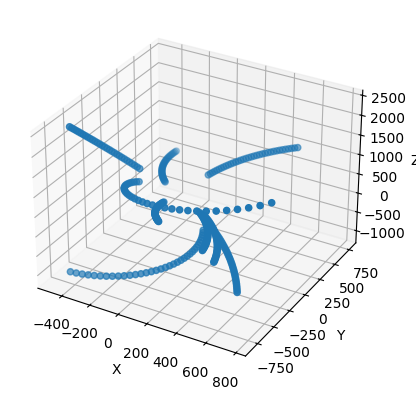

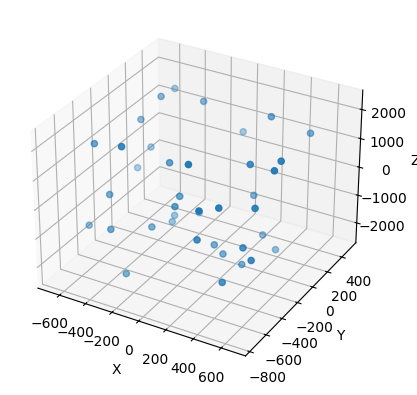

In [74]:
df_track = df_test.loc[df_test['class'] == 1]
df_noise = df_test.loc[df_test['class'] == 0]

draw_event(df_track)
draw_event(df_noise)

### Подсчет f1_score

In [66]:
import numpy as np
from sklearn.metrics import f1_score

f1 = f1_score(y_test_right, y_test)

print(f1)

1.0
